In [56]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


Пропусков нет, тип данных Month - object, мне нужен datetime

In [4]:
df['Month'] = pd.to_datetime(df['Month'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [5]:
df.set_index('Month', inplace=True)

In [6]:
df.index.is_monotonic_increasing

True

У меня соблюдён хронологический порядок

Оставьте для аналитики лишь с 1952 по 1957 год (включительно)

In [7]:
data = df['1952':'1957']
print(data.index.min(), data.index.max())

1952-01-01 00:00:00 1957-12-01 00:00:00


In [8]:
decomposed = seasonal_decompose(data['#Passengers'])

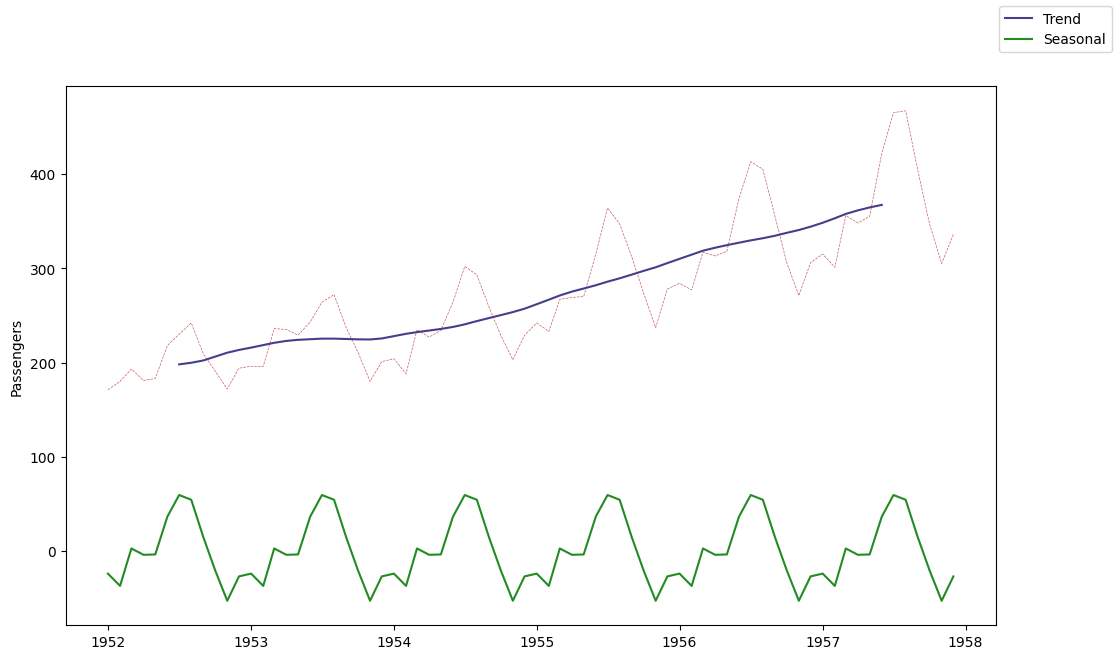

In [9]:
fig, ax = plt.subplots(1, 1, figsize=[12, 7])

ax.plot(data['#Passengers'], c='indianred', linewidth=0.5, linestyle='--')
ax.plot(decomposed.trend, c='darkslateblue', label='Trend')
ax.plot(decomposed.seasonal, c='forestgreen', label='Seasonal')
ax.set_ylabel('Passengers')

fig.legend()

На данном графике наблюдается тренд - количество пассажиров с каждым годом увеличивается, а также прослеживается сезонность причем ежегодная, ряд является НЕ стационарным, так как со временем меняется среднее и амплитуда

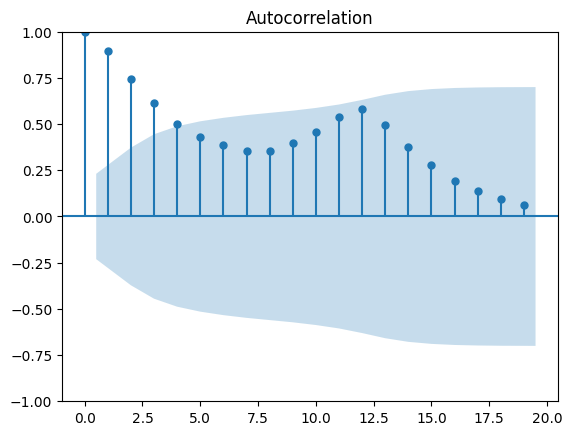

In [10]:
fig = tsaplots.plot_acf(data['#Passengers'])
plt.show() 

Самая сильная автокорреляция у первого сдвига, значит, каждый следующий месяц похож на предыдущий, что подтверждает тренд

После первого лага автокорреляция падает и её пик приходится на 12 лаг - подтверждение ежегодной сезонности

In [11]:
def make_features(data, max_lag=(1,3,6,12), window=(3,6,12)):
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year

    for i in max_lag:
        data[f'lag_{i}'] = data['#Passengers'].shift(i)

    for i in window:
        data[f'rolling_mean_{i}'] = data['#Passengers'].rolling(i).mean().shift(1)

    return data

In [12]:
data_with_feature = make_features(data.copy())
data_with_feature.head()

,#Passengers,quarter,month,year,lag_1,lag_3,lag_6,lag_12,rolling_mean_3,rolling_mean_6,rolling_mean_12
Month,,,,,,,,,,,
1952-01-01,171,1,1,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952-02-01,180,1,2,1952,171.0,NaN,NaN,NaN,NaN,NaN,NaN
1952-03-01,193,1,3,1952,180.0,NaN,NaN,NaN,NaN,NaN,NaN
1952-04-01,181,2,4,1952,193.0,171.0,NaN,NaN,181.333333,NaN,NaN
1952-05-01,183,2,5,1952,181.0,180.0,NaN,NaN,184.666667,NaN,NaN


In [13]:
train, test = train_test_split(data_with_feature.dropna(), shuffle=False, test_size=0.2)

train_target = train['#Passengers']
train_feature = train.drop(['#Passengers'], axis=1)
test_target = test['#Passengers']
test_feature = test.drop(['#Passengers'], axis=1)

scaler = StandardScaler().fit(train_feature)
train_norm = scaler.transform(train_feature)
test_norm = scaler.transform(test_feature)

model = LinearRegression()
model.fit(train_norm, train_target)

train_predict = pd.Series(model.predict(train_norm))
train_predict.index = train_feature.index
test_predict = pd.Series(model.predict(test_norm))
test_predict.index = test_feature.index

print("MAE обучающей выборки:" ,mean_absolute_error(train_target, train_predict))
print("MAE тестовой выборки: " ,mean_absolute_error(test_target, test_predict))

MAE обучающей выборки: 9.799998189892905
MAE тестовой выборки:  10.77029813705596


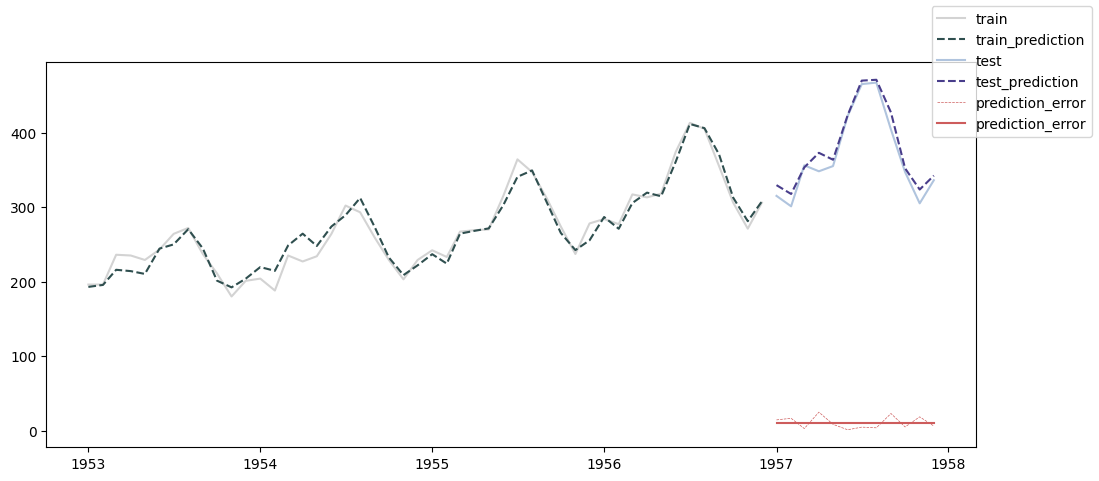

In [14]:
fig, ax = plt.subplots(1, 1, figsize=[12,5])

error = abs(test['#Passengers']-test_predict)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = test.index

ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_predict, c='darkslategrey', label='train_prediction', linestyle='--')
ax.plot(test_target, c='lightsteelblue', label='test')
ax.plot(test_predict, c='darkslateblue', label='test_prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend()

Предсказания, как на тренировочных, так и на тестовых данных очень близки  креальным, MAE достаточно низкое

In [15]:
data_with_feature_all = make_features(df.copy())
data_with_feature_all.dropna(inplace=True)

In [16]:
data_last_with_feature = data_with_feature_all['1958':'1960']
data_last_with_feature.head()

,#Passengers,quarter,month,year,lag_1,lag_3,lag_6,lag_12,rolling_mean_3,rolling_mean_6,rolling_mean_12
Month,,,,,,,,,,,
1958-01-01,340,1,1,1958,336.0,347.0,465.0,315.0,329.333333,387.333333,368.416667
1958-02-01,318,1,2,1958,340.0,305.0,467.0,301.0,327.000000,366.500000,370.500000
1958-03-01,362,1,3,1958,318.0,336.0,404.0,356.0,331.333333,341.666667,371.916667
1958-04-01,348,2,4,1958,362.0,340.0,347.0,348.0,340.000000,334.666667,372.416667
1958-05-01,363,2,5,1958,348.0,318.0,305.0,355.0,342.666667,334.833333,372.416667


In [17]:
train_last, test_last = train_test_split(data_last_with_feature, shuffle=False, test_size=0.2)

train_target_last = train_last['#Passengers']
train_feature_last = train_last.drop(['#Passengers'], axis=1)
test_target_last = test_last['#Passengers']
test_feature_last = test_last.drop(['#Passengers'], axis=1)

scaler = StandardScaler().fit(train_feature_last)
train_norm_last = scaler.transform(train_feature_last)
test_norm_last = scaler.transform(test_feature_last)

model.fit(train_norm_last, train_target_last)

train_predict_last = pd.Series(model.predict(train_norm_last))
train_predict_last.index = train_feature_last.index
test_predict_last = pd.Series(model.predict(test_norm_last))
test_predict_last.index = test_feature_last.index

print("MAE тестовой выборки: " , mean_absolute_error(test_target_last, test_predict_last))

MAE тестовой выборки:  23.590873299582583


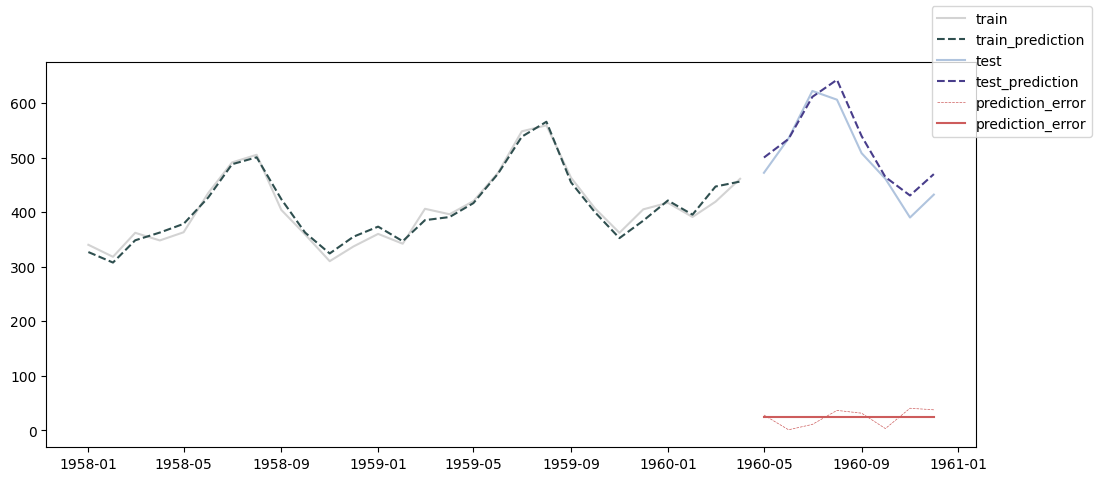

In [18]:
fig, ax = plt.subplots(1, 1, figsize=[12,5])

error_last = abs(test_last['#Passengers']-test_predict_last)
error_mean_last = pd.Series([error_last.mean()] * error_last.shape[0])
error_mean_last.index = test_last.index

ax.plot(train_target_last, c='lightgrey', label='train')
ax.plot(train_predict_last, c='darkslategrey', label='train_prediction', linestyle='--')
ax.plot(test_target_last, c='lightsteelblue', label='test')
ax.plot(test_predict_last, c='darkslateblue', label='test_prediction', linestyle='--')
ax.plot(error_last, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean_last, c='indianred', label='prediction_error')

fig.legend()

Модель предсказывает пассажиропоток в 1958–1960 гг. хорошо, MAE соответствует условию, график подтверждает адекватность прогноза

# Задание PRO

AR-модель

In [22]:
lags = [1, 3, 6, 12]
mae_lags = {}

y = df['#Passengers']

train = y.loc['1952':'1956']
val = y.loc['1957']

In [26]:

for i in lags:
    model = AutoReg(train, lags=i, trend='c').fit()
    predict  = model.predict(start=val.index[0], end=val.index[-1])
    mae = mean_absolute_error(val, predict)
    mae_lags[i] = mae
    print(f"lag={i:>2}  MAE={mae_lags[i]:.3f}")

best_lag = min(mae_lags, key=mae_lags.get)
print("Best lag:", best_lag, "MAE:", mae_lags[best_lag])

lag= 1  MAE=79.799
lag= 3  MAE=80.003
lag= 6  MAE=59.064
lag=12  MAE=18.463
Best lag: 12 MAE: 18.46317945061597


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeInd

In [27]:
best_model = AutoReg(train, lags=best_lag, trend='c').fit()
val_pred   = best_model.predict(start=val.index[0], end=val.index[-1])

c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


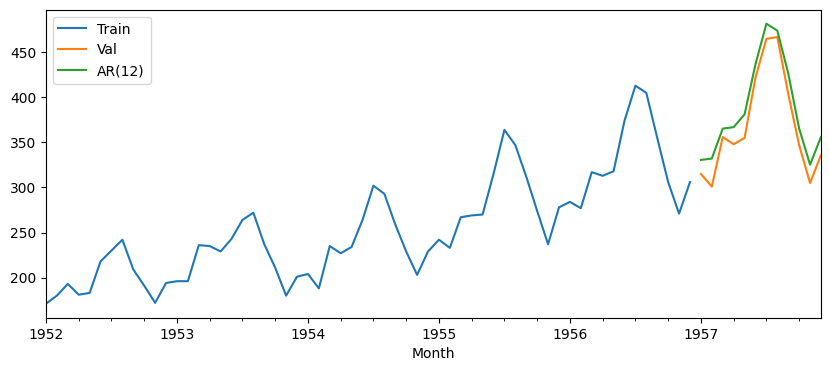

In [33]:
fig, ax = plt.subplots(figsize=(10, 4))
train.plot(ax=ax, label='Train')
val.plot(ax=ax,   label='Val')
val_pred.plot(ax=ax, label=f'AR({best_lag})')
ax.legend()

ARMA-модель

In [36]:
train2 = y.loc['1952':'1956']
val2 = y.loc['1957']

grid_p = [0,1,2]
grid_q = [0,1,2]
mae_arma = {}

for p in grid_p:
    for q in grid_q:
            model = ARIMA(train2, order=(p,0,q), trend='c').fit()
            predict  = model.predict(start=val2.index[0], end=val2.index[-1]).reindex(val2.index)
            mae_arma[(p,q)] = mean_absolute_error(val2, predict)
            print(f'(p,q)=({p},{q})  MAE={mae_arma[(p,q)]:.2f}')

best_pq = min(mae_arma, key=mae_arma.get)
print('Best ARMA:', best_pq, 'MAE:', mae_arma[best_pq])

c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-package

(p,q)=(0,0)  MAE=113.78
(p,q)=(0,1)  MAE=109.95
(p,q)=(0,2)  MAE=106.89
(p,q)=(1,0)  MAE=88.76
(p,q)=(1,1)  MAE=89.95
(p,q)=(1,2)  MAE=86.93
(p,q)=(2,0)  MAE=92.99
(p,q)=(2,1)  MAE=86.94


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-package

(p,q)=(2,2)  MAE=88.30
Best ARMA: (1, 2) MAE: 86.93108225452106


In [48]:
best_model_2 = ARIMA(train2, order=(1,0,2), trend='c').fit()
val_pred_2   = best_model_2.predict(start=val2.index[0], end=val2.index[-1])

c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


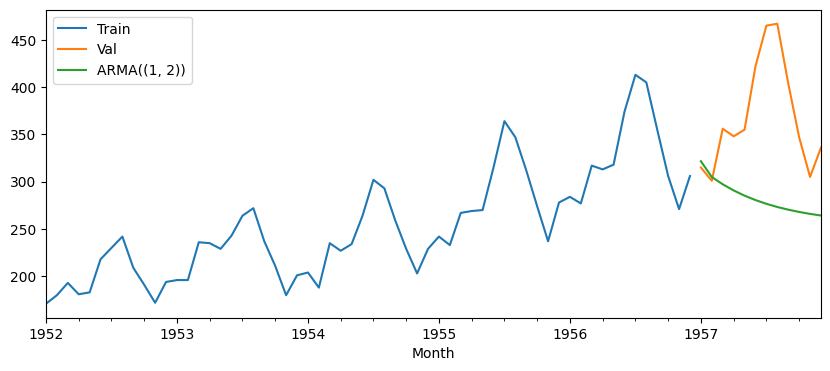

In [49]:
fig, ax = plt.subplots(figsize=(10, 4))
train2.plot(ax=ax, label='Train')
val2.plot(ax=ax,   label='Val')
val_pred_2.plot(ax=ax, label=f'ARMA({best_pq})')
ax.legend()

ARIMA-модель

In [53]:
scores_arima = {}
best, best_mae = None, np.inf

for p in range(4):
    for d in range(1, 4):
        for q in range(4):
            arima = ARIMA(train, order=(p,d,q), trend='n',
                    enforce_stationarity=True, enforce_invertibility=True).fit()
        pred = arima.predict(start=val.index[0], end=val.index[-1])
        mae  = mean_absolute_error(val, pred)
        scores_arima[(p,d,q)] = mae
        if mae < best_mae:
                best, best_mae = (p,d,q), mae

print('Best ARIMA:', best, 'MAE:', round(best_mae, 2))

c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-package

Best ARIMA: (3, 1, 3) MAE: 36.63


In [54]:
best_model_3 = ARIMA(train2, order=(3,1,3), trend='n').fit()
val_pred_3   = best_model_3.predict(start=val2.index[0], end=val2.index[-1])

c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


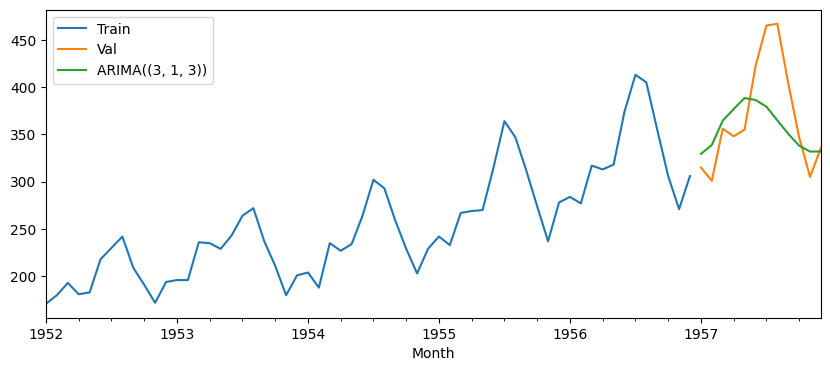

In [55]:
fig, ax = plt.subplots(figsize=(10, 4))
train.plot(ax=ax, label='Train')
val.plot(ax=ax,   label='Val')
val_pred_3.plot(ax=ax, label=f'ARIMA({best})')
ax.legend()

проверка дифференцирования

In [62]:
from statsmodels.tsa.stattools import adfuller

def adf_p(series):
    return adfuller(series.dropna(), autolag='AIC')[1]

y_train = y.loc['1952':'1956']

print('ADF p on level    :', adf_p(y_train))
print('ADF p on diff(1)  :', adf_p(y_train.diff(1)))
print('ADF p on diff(2)  :', adf_p(y_train.diff(2)))

ADF p on level    : 1.0
ADF p on diff(1)  : 0.3571808552563752
ADF p on diff(2)  : 0.3589862113724137


SARIMA-модель

In [59]:
best, best_mae = None, np.inf
for p in range(3):
    for q in range(3):
        for P in range(2):
            for Q in range(2):
                model = SARIMAX(train,
                          order=(p,1,q),
                          seasonal_order=(P,1,Q,12),
                          enforce_stationarity=True,
                          enforce_invertibility=True
                         ).fit()
            pred = model.predict(start=val.index[0], end=val.index[-1])
            mae    = mean_absolute_error(val, pred)
            if mae < best_mae:
                best_mae = mae
                best = (p,1,q,P,1,Q,12)
            print((p,1,q,P,1,Q,12), 'MAE=', round(mae,2))

c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-package

(0, 1, 0, 0, 1, 1, 12) MAE= 12.87
(0, 1, 0, 1, 1, 1, 12) MAE= 13.12


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-package

(0, 1, 1, 0, 1, 1, 12) MAE= 12.22


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-package

(0, 1, 1, 1, 1, 1, 12) MAE= 12.47


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-package

(0, 1, 2, 0, 1, 1, 12) MAE= 11.47


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-package

(0, 1, 2, 1, 1, 1, 12) MAE= 11.81
(1, 1, 0, 0, 1, 1, 12) MAE= 12.35


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-package

(1, 1, 0, 1, 1, 1, 12) MAE= 12.58


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-package

(1, 1, 1, 0, 1, 1, 12) MAE= 10.7


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-package

(1, 1, 1, 1, 1, 1, 12) MAE= 11.03


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-package

(1, 1, 2, 0, 1, 1, 12) MAE= 10.74


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-package

(1, 1, 2, 1, 1, 1, 12) MAE= 11.07
(2, 1, 0, 0, 1, 1, 12) MAE= 12.25


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-package

(2, 1, 0, 1, 1, 1, 12) MAE= 12.57


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

(2, 1, 1, 0, 1, 1, 12) MAE= 10.73


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

(2, 1, 1, 1, 1, 1, 12) MAE= 11.07


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Alexey\Deskt

(2, 1, 2, 0, 1, 1, 12) MAE= 16.46


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Alexey\Deskt

(2, 1, 2, 1, 1, 1, 12) MAE= 16.8


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [63]:
print('Best SARIMA:', best, 'MAE:', round(best_mae, 2))

Best SARIMA: (1, 1, 1, 0, 1, 1, 12) MAE: 10.7


In [65]:
best_model_4 = SARIMAX(train,
                          order=(1,1,1),
                          seasonal_order=(0,1,1,12),
                          enforce_stationarity=True,
                          enforce_invertibility=True
                         ).fit()
val_pred_4   = best_model_4.predict(start=val.index[0], end=val.index[-1])

c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


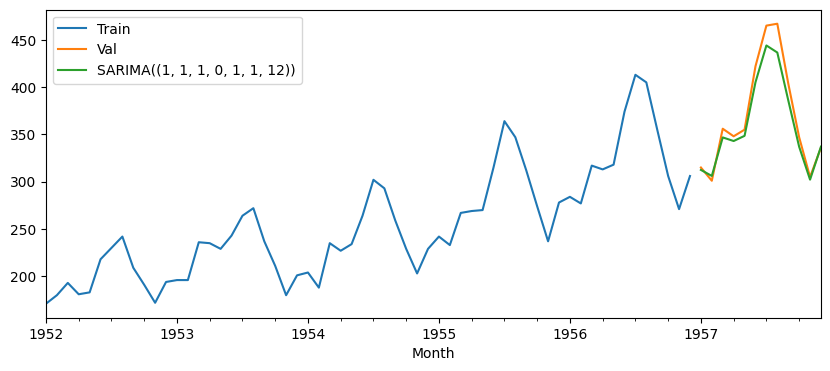

In [66]:
fig, ax = plt.subplots(figsize=(10, 4))
train.plot(ax=ax, label='Train')
val.plot(ax=ax,   label='Val')
val_pred_4.plot(ax=ax, label=f'SARIMA({best})')
ax.legend()

# Вывод

Лучшая модель — SARIMA(1,1,1)×(0,1,1,12), MAE≈10.7 на валидации. Она существенно обошла AR(12) (≈18.5), ARIMA(3,1,3) (≈36.6) и все ARMA.